# Bài Tập Thực Hành Lab 6: Logistic Regression và Softmax

Bài tập này sẽ giúp bạn củng cố kiến thức về:
- Hàm Sigmoid và tính chất
- Logistic Regression cho phân loại nhị phân
- Softmax Regression cho phân loại đa lớp
- Cross Entropy Loss
- Gradient Descent cho tối ưu hóa


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import pandas as pd
from sklearn.datasets import make_classification, make_blobs
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Thiết lập để hiển thị đồ thị đẹp hơn
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12


## Bài 1: Khảo sát hàm Sigmoid

### Câu 1.1: Triển khai hàm Sigmoid
Viết hàm `sigmoid(x)` tính giá trị của hàm sigmoid tại điểm x.

**Công thức:** $\sigma(x) = \frac{1}{1+e^{-x}}$


In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    pass

# Test hàm sigmoid
print(f"sigmoid(0) = {sigmoid(0)}")
print(f"sigmoid(1) = {sigmoid(1)}")
print(f"sigmoid(-1) = {sigmoid(-1)}")
print(f"sigmoid(10) = {sigmoid(10)}")
print(f"sigmoid(-10) = {sigmoid(-10)}")

# Đáp án mong đợi:
# sigmoid(0) = 0.5
# sigmoid(1) ≈ 0.731
# sigmoid(-1) ≈ 0.269
# sigmoid(10) ≈ 1.0
# sigmoid(-10) ≈ 0.0


sigmoid(0) = 0.5
sigmoid(1) = 0.7310585786300049
sigmoid(-1) = 0.2689414213699951
sigmoid(10) = 0.9999546021312976
sigmoid(-10) = 4.5397868702434395e-05


### Câu 1.2: Vẽ đồ thị hàm Sigmoid
Vẽ đồ thị hàm sigmoid trong khoảng [-10, 10] và đánh dấu các điểm đặc biệt.


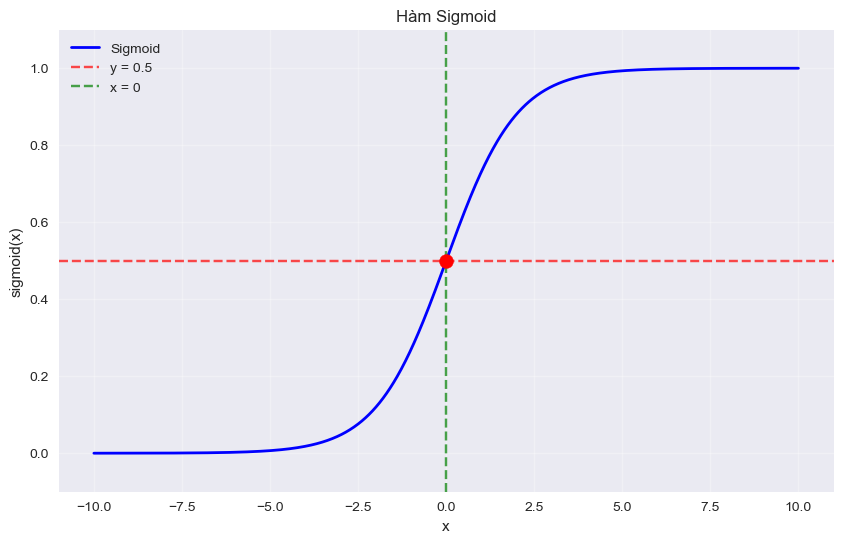

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Định nghĩa hàm sigmoid
def sigmoid(x):
    """
    Tính giá trị của hàm sigmoid: f(x) = 1 / (1 + e^(-x))
    
    Parameters:
    x : array-like
        Giá trị đầu vào
        
    Returns:
    array-like: Giá trị hàm sigmoid tại x
    """
    return 1 / (1 + np.exp(-x))

# Tạo mảng x từ -10 đến 10
x = np.linspace(-10, 10, 1000)

# Tính giá trị sigmoid
y = sigmoid(x)

# Vẽ đồ thị
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b-', linewidth=2, label='Sigmoid')
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='y = 0.5')
plt.axvline(x=0, color='g', linestyle='--', alpha=0.7, label='x = 0')
plt.scatter([0], [0.5], color='red', s=100, zorder=5)
plt.xlabel('x')
plt.ylabel('sigmoid(x)')
plt.title('Hàm Sigmoid')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(-0.1, 1.1)
plt.show()

## Bài 2: Logistic Regression từ đầu

### Câu 2.1: Triển khai Cross Entropy Loss
Viết hàm tính Cross Entropy Loss cho bài toán phân loại nhị phân.

**Công thức:** $\text{Loss} = -[y \log(\hat{y}) + (1-y) \log(1-\hat{y})]$


In [8]:
def cross_entropy_loss(y_true, y_pred):
    """
    Tính Cross Entropy Loss
    
    Args:
        y_true: nhãn thực tế (0 hoặc 1)
        y_pred: xác suất dự đoán (từ 0 đến 1)
    
    Returns:
        Giá trị Cross Entropy Loss
    """
    # TODO: Triển khai công thức Cross Entropy
    # Lưu ý: thêm epsilon nhỏ để tránh log(0)
    epsilon = 1e-15
    # Clipping để tránh log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    
    loss = -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss
    pass

# Test hàm Cross Entropy
print("=== Test Cross Entropy Loss ===")
print(f"Loss khi y_true=1, y_pred=0.9: {cross_entropy_loss(1, 0.9):.4f}")
print(f"Loss khi y_true=1, y_pred=0.1: {cross_entropy_loss(1, 0.1):.4f}")
print(f"Loss khi y_true=0, y_pred=0.1: {cross_entropy_loss(0, 0.1):.4f}")
print(f"Loss khi y_true=0, y_pred=0.9: {cross_entropy_loss(0, 0.9):.4f}")

print("\nNhận xét:")
print("- Khi dự đoán đúng (y_true=1, y_pred gần 1): Loss nhỏ")
print("- Khi dự đoán sai (y_true=1, y_pred gần 0): Loss lớn")


=== Test Cross Entropy Loss ===
Loss khi y_true=1, y_pred=0.9: 0.1054
Loss khi y_true=1, y_pred=0.1: 2.3026
Loss khi y_true=0, y_pred=0.1: 0.1054
Loss khi y_true=0, y_pred=0.9: 2.3026

Nhận xét:
- Khi dự đoán đúng (y_true=1, y_pred gần 1): Loss nhỏ
- Khi dự đoán sai (y_true=1, y_pred gần 0): Loss lớn


### Câu 2.2: Triển khai Logistic Regression
Xây dựng lớp LogisticRegression với gradient descent.

**Các bước chính:**
1. Khởi tạo weights và bias
2. Forward pass: tính linear model và áp dụng sigmoid
3. Tính cost (Cross Entropy)
4. Backward pass: tính gradients
5. Cập nhật parameters


In [11]:
import numpy as np

def sigmoid(z):
    """Hàm sigmoid: f(z) = 1 / (1 + e^(-z))"""
    return 1 / (1 + np.exp(-z))

class LogisticRegression:
    def __init__(self, learning_rate=0.01, max_iterations=1000, tolerance=1e-6):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.weights = None
        self.bias = None
        self.cost_history = []
    
    def fit(self, X, y):
        """
        Huấn luyện mô hình Logistic Regression
        
        Args:
            X: ma trận đặc trưng (n_samples, n_features)
            y: vector nhãn (n_samples,)
        """
        n_samples, n_features = X.shape
        
        # Khởi tạo weights và bias
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # Gradient descent
        for i in range(self.max_iterations):
            # Tính linear model (z = X * w + b)
            linear_model = np.dot(X, self.weights) + self.bias
            
            # Tính predictions qua sigmoid
            y_predicted = sigmoid(linear_model)
            
            # Tính cost (Cross Entropy trung bình)
            # Thêm epsilon để tránh log(0)
            epsilon = 1e-15
            y_predicted_clipped = np.clip(y_predicted, epsilon, 1 - epsilon)
            cost = -np.mean(y * np.log(y_predicted_clipped) + 
                           (1 - y) * np.log(1 - y_predicted_clipped))
            self.cost_history.append(cost)
            
            # Tính gradients
            # dw = (1/n) * X.T * (y_pred - y)
            # db = (1/n) * sum(y_pred - y)
            dw = (1/n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1/n_samples) * np.sum(y_predicted - y)
            
            # Cập nhật parameters
            self.weights = self.weights - self.learning_rate * dw
            self.bias = self.bias - self.learning_rate * db
            
            # Kiểm tra hội tụ
            if i > 0 and abs(self.cost_history[-2] - self.cost_history[-1]) < self.tolerance:
                print(f"Hội tụ sau {i+1} iterations")
                break
    
    def predict(self, X):
        """Dự đoán nhãn cho dữ liệu mới"""
        # Tính linear model và áp dụng sigmoid
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = sigmoid(linear_model)
        predictions = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(predictions)
    
    def predict_proba(self, X):
        """Dự đoán xác suất cho dữ liệu mới"""
        # Tính xác suất
        linear_model = np.dot(X, self.weights) + self.bias
        return sigmoid(linear_model)

## Bài 3: Softmax Regression

### Câu 3.1: Triển khai hàm Softmax
Viết hàm softmax ổn định (tránh overflow).

**Công thức:** $\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{C} e^{z_j}}$

**Phiên bản ổn định:** $\text{softmax}(z_i) = \frac{e^{z_i - \max(z)}}{\sum_{j=1}^{C} e^{z_j - \max(z)}}$


In [12]:
import numpy as np

def softmax_stable(Z):
    """
    Tính softmax ổn định cho ma trận Z
    
    Args:
        Z: ma trận (n_classes, n_samples)
    
    Returns:
        Ma trận xác suất softmax
    """
    # Bước 1: Trừ đi max theo axis=0 để tránh overflow
    Z_shifted = Z - np.max(Z, axis=0, keepdims=True)
    
    # Bước 2: Tính exponential
    exp_Z = np.exp(Z_shifted)
    
    # Bước 3: Chia cho tổng
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

# Test hàm softmax
Z = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=float)
print("Input Z:")
print(Z)
print("\nSoftmax output:")
result = softmax_stable(Z)
print(result)
print(f"\nTổng mỗi cột (phải bằng 1): {np.sum(result, axis=0)}")

# Test với số lớn để kiểm tra tính ổn định
Z_large = np.array([[100, 200], [300, 400], [500, 600]], dtype=float)
print("\n=== Test với số lớn ===")
try:
    result_large = softmax_stable(Z_large)
    print("Softmax ổn định hoạt động tốt!")
    print(f"Tổng: {np.sum(result_large, axis=0)}")
except:
    print("Có lỗi xảy ra - cần cải thiện hàm softmax")

Input Z:
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]

Softmax output:
[[0.00235563 0.00235563 0.00235563]
 [0.04731416 0.04731416 0.04731416]
 [0.95033021 0.95033021 0.95033021]]

Tổng mỗi cột (phải bằng 1): [1. 1. 1.]

=== Test với số lớn ===
Softmax ổn định hoạt động tốt!
Tổng: [1. 1.]


### Câu 3.2: One-hot encoding
Viết hàm chuyển đổi nhãn sang dạng one-hot encoding.

**Ví dụ:** `[0, 2, 1]` → `[[1, 0, 0], [0, 0, 1], [0, 1, 0]]`


In [13]:
import numpy as np

def convert_labels(y, num_classes=None):
    """
    Chuyển đổi nhãn 1D thành ma trận one-hot
    
    Args:
        y: mảng nhãn 1D
        num_classes: số lượng classes (nếu None thì tự động tính)
    
    Returns:
        Ma trận one-hot (num_classes, len(y))
    """
    if num_classes is None:
        num_classes = len(np.unique(y))
    
    # Tạo ma trận one-hot
    # Cách 2: Sử dụng np.eye và indexing
    one_hot = np.eye(num_classes)[:, y]
    
    # Hoặc có thể dùng cách 3:
    # one_hot = np.zeros((num_classes, len(y)))
    # for i, label in enumerate(y):
    #     one_hot[label, i] = 1
    
    return one_hot

# Test hàm convert_labels
y_test = np.array([0, 2, 1, 0, 1])
print(f"Original labels: {y_test}")
Y_onehot = convert_labels(y_test, 3)
print(f"One-hot encoding:")
print(Y_onehot)
print(f"Shape: {Y_onehot.shape}")

# Kiểm tra tính đúng đắn
print("\n=== Kiểm tra ===")
for i, label in enumerate(y_test):
    print(f"Sample {i}: label={label}, one-hot={Y_onehot[:, i]}")

Original labels: [0 2 1 0 1]
One-hot encoding:
[[1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 1.]
 [0. 1. 0. 0. 0.]]
Shape: (3, 5)

=== Kiểm tra ===
Sample 0: label=0, one-hot=[1. 0. 0.]
Sample 1: label=2, one-hot=[0. 0. 1.]
Sample 2: label=1, one-hot=[0. 1. 0.]
Sample 3: label=0, one-hot=[1. 0. 0.]
Sample 4: label=1, one-hot=[0. 1. 0.]


## Bài 4: Bài tập thực hành với dữ liệu

### Câu 4.1: Test với dữ liệu nhị phân
Tạo dữ liệu và test mô hình Logistic Regression.


Training set: 800 samples
Test set: 200 samples
Accuracy: 0.9000


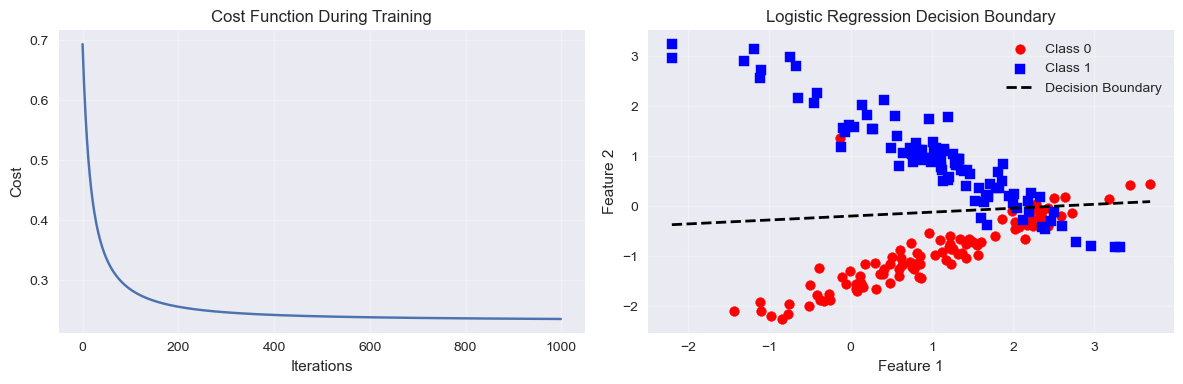

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Define the sigmoid function
def sigmoid(z):
    """Hàm sigmoid: f(z) = 1 / (1 + e^(-z))"""
    return 1 / (1 + np.exp(-z))

# Implement LogisticRegression class
class LogisticRegression:
    def __init__(self, learning_rate=0.01, max_iterations=1000, tolerance=1e-6):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.weights = None
        self.bias = None
        self.cost_history = []
    
    def fit(self, X, y):
        """
        Huấn luyện mô hình Logistic Regression
        
        Args:
            X: ma trận đặc trưng (n_samples, n_features)
            y: vector nhãn (n_samples,)
        """
        n_samples, n_features = X.shape
        
        # Khởi tạo weights và bias
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # Gradient descent
        for i in range(self.max_iterations):
            # Tính linear model (z = X * w + b)
            linear_model = np.dot(X, self.weights) + self.bias
            
            # Tính predictions qua sigmoid
            y_predicted = sigmoid(linear_model)
            
            # Tính cost (Cross Entropy trung bình)
            # Thêm epsilon để tránh log(0)
            epsilon = 1e-15
            y_predicted_clipped = np.clip(y_predicted, epsilon, 1 - epsilon)
            cost = -np.mean(y * np.log(y_predicted_clipped) + 
                           (1 - y) * np.log(1 - y_predicted_clipped))
            self.cost_history.append(cost)
            
            # Tính gradients
            # dw = (1/n) * X.T * (y_pred - y)
            # db = (1/n) * sum(y_pred - y)
            dw = (1/n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1/n_samples) * np.sum(y_predicted - y)
            
            # Cập nhật parameters
            self.weights = self.weights - self.learning_rate * dw
            self.bias = self.bias - self.learning_rate * db
            
            # Kiểm tra hội tụ
            if i > 0 and abs(self.cost_history[-2] - self.cost_history[-1]) < self.tolerance:
                print(f"Hội tụ sau {i+1} iterations")
                break
    
    def predict(self, X):
        """Dự đoán nhãn cho dữ liệu mới"""
        # Tính linear model và áp dụng sigmoid
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = sigmoid(linear_model)
        predictions = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(predictions)
    
    def predict_proba(self, X):
        """Dự đoán xác suất cho dữ liệu mới"""
        # Tính xác suất
        linear_model = np.dot(X, self.weights) + self.bias
        return sigmoid(linear_model)

# Tạo dữ liệu giả lập cho phân loại nhị phân
np.random.seed(42)
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, 
                          n_informative=2, n_clusters_per_class=1, random_state=42)

# Chia dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Huấn luyện mô hình
model = LogisticRegression(learning_rate=0.1, max_iterations=1000)
model.fit(X_train, y_train)

# Dự đoán
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

# Tính accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.4f}")

# Vẽ đồ thị cost function
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(model.cost_history)
plt.title('Cost Function During Training')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.grid(True, alpha=0.3)

# Vẽ dữ liệu và decision boundary
plt.subplot(1, 2, 2)
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], c='red', marker='o', label='Class 0')
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], c='blue', marker='s', label='Class 1')

# Vẽ decision boundary (nếu có thể)
if model.weights[1] != 0:
    x_boundary = np.linspace(X_test[:, 0].min(), X_test[:, 0].max(), 100)
    y_boundary = -(model.weights[0] * x_boundary + model.bias) / model.weights[1]
    plt.plot(x_boundary, y_boundary, 'k--', linewidth=2, label='Decision Boundary')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Logistic Regression Decision Boundary')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()